# Size-based NPZ model

Our third model application is a size-structured plankton community model in an idealized physical setting, similar to a chemostat. The presented model is an adaptation of the ASTroCAT model, developed by Neil Banas.
> Banas, N. S. (2011). Adding complex trophic interactions to a size-spectral plankton model: Emergent diversity patterns and limits on predictability. Ecological Modelling, 222(15), 2663-2675.

ASTroCAT was developed as a tool to investigate the complex trophic interactions between phytoplankton and zooplankton in a systematic simplified setting, resolving a diverse plankton community via a size spectrum. Cell or organism size is used in this model as a “master trait”, defining the parameters of specific plankton types via allometric functions, taken from literature (Litchman et al. 2008). This allows for a functional and quantifiable model to investigate mechanisms affecting and sustaining phytoplankton diversity. It is beautifully presented in the original publication and on the [website of Neil Banas](https://neilbanas.com/projects/astrocat/).

Banas considered model dynamics under variable forcing or with stochastic grazing parameters. Here, we focus on the basic parameter setup under constant forcing. The model features an allometric description of multiple size-classes for phytoplankton growing on a single nutrient and zooplankton grazing on phytoplankton. While trophic interactions between size classes are highly resolved, other ecological processes are neglected (e.g., there are no detrital or regeneration pathways).  

## System of equations

The following is a simplied overview over the system of equations. Please reference the original publication, or the current publication that presents XSO and Phydra, for a detailed description.

$$
    \frac{d N}{d t} = 
    f \ N_0 % Nutrient mixing
    +  (1- \epsilon - f_{eg}) \ \sum_{j} \sum_{i} G_P^{ij} % Unassimilated grazing by Z
    - \sum_{i} ( \mu_{max}^i \ \gamma_i^N \ P_i) % Phytoplankton gains
$$

$$
    \frac{d P_i}{d t} =
    \mu_{max}^i \  \gamma_i^N \   P_i  % Phytoplankton gains
    - m_P  \ \mu_{max}^i \ P_i % Linear mortality
    - \sum_{j} G_P^{ij} % Z grazing
$$

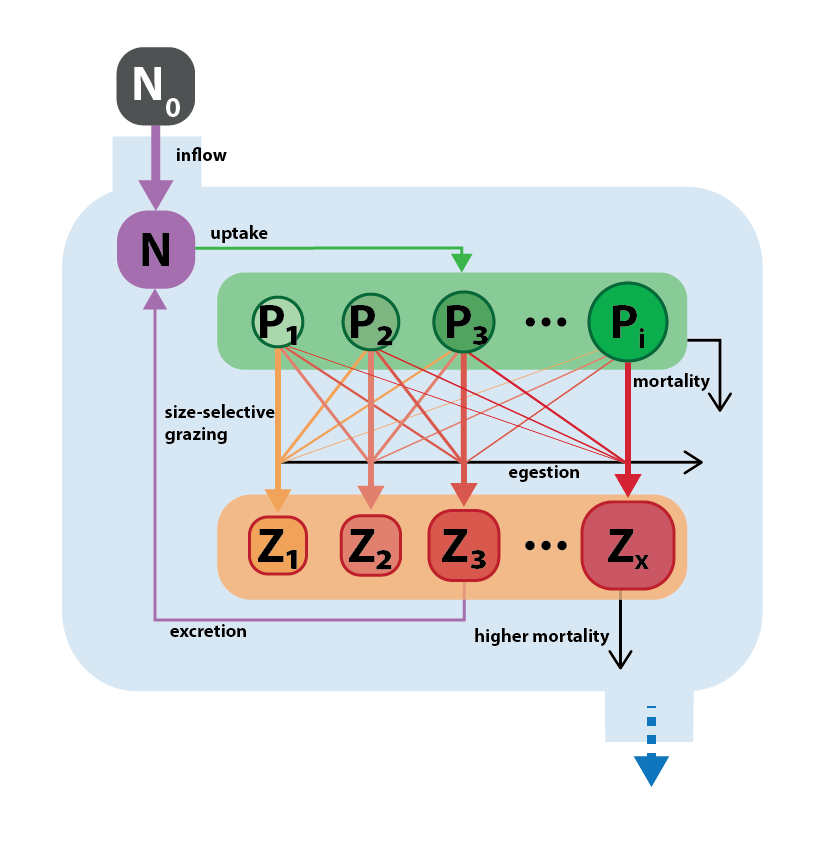

In [1]:
from IPython.display import Image
Image(filename=('images/03_schematics_NPZSizeBased.png'), width=600)

In [2]:
# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import xso

# The model object

In [3]:
# allow relative import of local directory
import sys
sys.path.append('..')

from phydra.models import NPxZxSizeBased

In [4]:
# We can find out more about the model object by simply printing it to the console:
print(NPxZxSizeBased)

<xsimlab.Model (13 processes, 33 inputs)>
Core
    solver_type              [in] solver type to use for model
Time
    time_input               [in] ('time',) sequence of time for wh...
Nutrient
    value_label              [in] label / nutrient concentration
    value_init               [in] initial value / nutrient concentr...
Phytoplankton
    biomass_label            [in] label / phytoplankton biomass
    biomass_init             [in] ('phyto',) initial value / phytop...
    phyto_index              [in] ('phyto',) index / size spectrum ...
Zooplankton
    biomass_label            [in] label / zooplankton biomass
    biomass_init             [in] ('zoo',) initial value / zooplank...
    zoo_index                [in] ('zoo',) index / size spectrum of...
N0
    forcing_label            [in] label / external nutrient
    value                    [in] parameter / constant value
Inflow
    var                      [in] label reference / variable affect...
    forcing                  [i

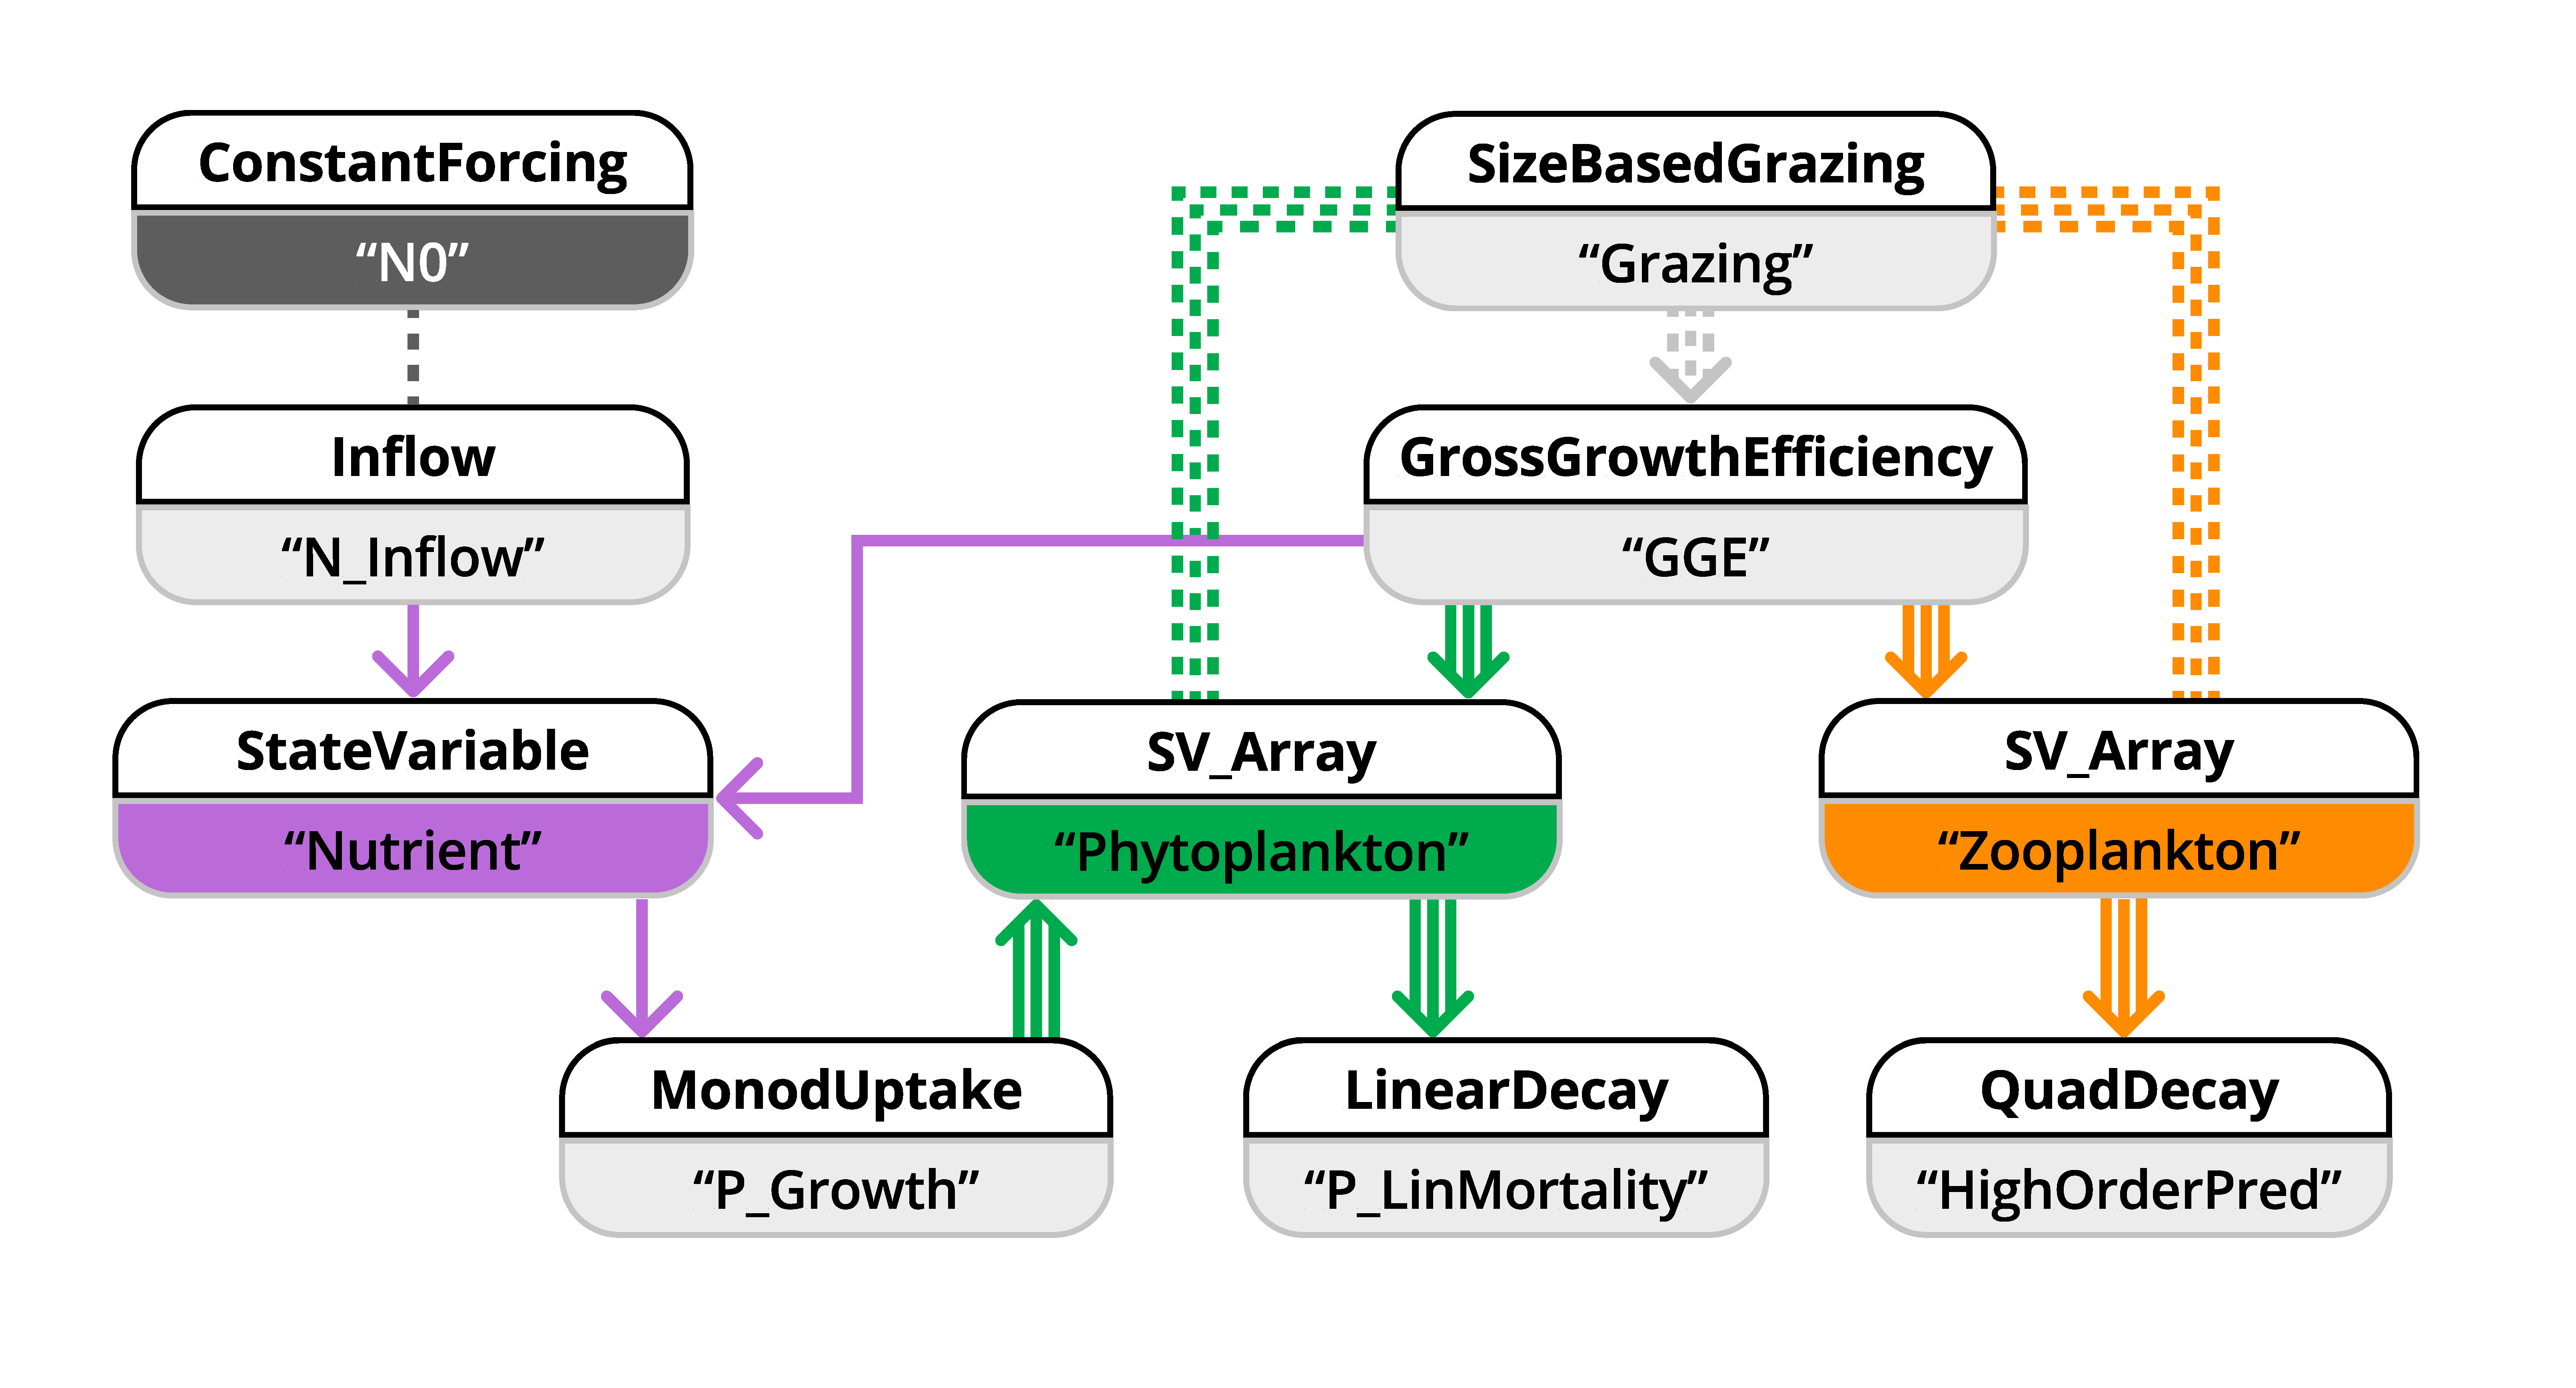

In [5]:
Image(filename=('images/03_code_NPZSizebased.png'), width=700)

# The model setup

This model lends itself well to highlight the flexibility of the XSO framework. A state variable defined within a _component_ can be defined with dimensions, so that it can represent an array of state variables of flexible size, as long as dimension labels match across interacting _components_. The size of the state variable array depends on the number of values supplied at model setup. The built-in vectorization allows the model to compute correctly and efficiently, even with large numbers of state variables. We showcase this feature by running the model with 2 to 50 size classes and comparing bulk phytoplankton biomass between runs. The only modification necessary is varying the number of values supplied at model setup.

## Allometric functions

In [6]:
def calculate_sizes(size_min, size_max, num):
    """initializes log spaced array of sizes from ESD size range"""
    numbers = np.array([i for i in range(num)])
    sizes = (np.log(size_max) - np.log(size_min))* numbers / (num-1) + np.log(size_min)
    return np.exp(sizes)

def calculate_zoo_I0(sizes):
    """initializes allometric Zooplankton ingestion rate based on array of sizes (ESD)"""
    return 26 * sizes ** -0.4

def calculate_phyto_mu0(sizes):
    """initializes allometric Phytoplankton maximum growth rate based on array of sizes (ESD)
    allometric relationships are taken from meta-analyses of lab data"""
    return 2.6 * sizes ** -0.45

def calculate_phyto_ks(sizes):
    """initializes allometric Phytoplankton half-saturation constant based on array of sizes (ESD)"""
    return sizes * .1

def calculate_opt_size(sizes):
    """Calculating optimal prey size from Zooplankton sizes"""
    return 0.65 * sizes ** 0.56


def init_phiP(phytosize, zoopreyoptsize):
    """creates matrix of feeding preferences [P...P10] for each [Z]"""
    phiP = np.array([[np.exp(-((np.log10(xpreyi) - np.log10(xpreyoptj)) / 0.25) ** 2)
                      for xpreyi in phytosize] for xpreyoptj in zoopreyoptsize])
    return phiP

### Defining parameters

We utilize functions to automatically create parameter arrays from the number of size classes of phytoplankton and zooplankton in the model, which can be set right below here:

In [7]:
# number size classes of phytoplankton and zooplankotn
PZ_num = 40

# create initial biomass
phyto_init = np.tile(.5/PZ_num, (PZ_num))
zoo_init = np.tile(.1/PZ_num, (PZ_num))

# calculate log-spaced size classes from ranges and total number
phyto_sizes = calculate_sizes(1.,20.,PZ_num)
zoo_sizes = 2.16 * phyto_sizes **1.79 

# ingestion
zoo_I0 = calculate_zoo_I0(zoo_sizes)

# growth
phyto_mu0 = calculate_phyto_mu0(phyto_sizes)
phyto_ks = calculate_phyto_ks(phyto_sizes)

# grazing
preyoptsize = calculate_opt_size(zoo_sizes)
phiP = init_phiP(phyto_sizes, preyoptsize)

### Visualize grazing preferences

Text(0.5, 1.0, 'Grazing Preferences across size classes')

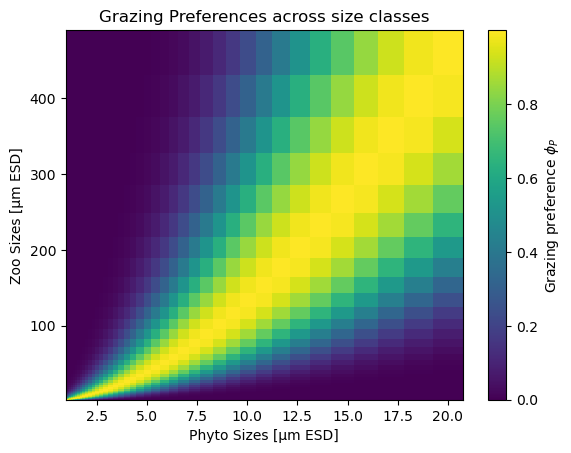

In [8]:
x, y = np.meshgrid(phyto_sizes, zoo_sizes)
plt.pcolormesh(x, y, phiP)
plt.colorbar(label='Grazing preference $\phi_P$')
plt.ylabel("Zoo Sizes [µm ESD]")
plt.xlabel("Phyto Sizes [µm ESD]")
plt.title("Grazing Preferences across size classes")

## Table of parameters

Parameters and allometric functions used for the size-based NPZ model:

| Description | Parameter | Value | Units |
| --- | --- | --- | --- | 
| Flow rate of external nutrient | $f$ | 1 | $d^{-1}$ |
| Prey half-saturation constant | $k_Z$ | 3 | µM N|
| External nutrient concentration | $N_0$ | 1 | µM N |
| Prey size tolerance | $\Delta size_{P}$ | 0.25 | $log_{10}$ $\mu m$|
| Mortality fraction of $\mu_{max}^i$ for $P_i$ | $m_P$ | 0.1 | $d^{-1}$|
| Zooplankton growth efficiency | $\epsilon$ | 0.33 | dimensionless|
| Fraction of grazing egested | $f_{eg}$ | 0.33 | dimensionless|
|  |  |  |  | 
| Maximum growth rate of $P_i$ |  $\mu_{max}^i$ | $$2.6 \left( \frac{size_i^{P}}{1\mu m} \right)^{-0.45}$$  | $d^{-1}$ |
| Nutrient half-saturation constant of $P_i$ | $k_N^i$ |  $$0.1 \left( \frac{size_i^{P}}{1\mu m} \right)$$ | µM  N |
| Maximum ingestion rate of $Z_j$ |  $I_Z^j$ | $$26 \left( \frac{size^i_{P}}{1\mu m} \right)^{-0.4}$$ | $d^{-1}$ |
| Optimum prey size of $Z_j$ | $size_{opt}^j$ |  $$0.65 \left( \frac{size_{P}^i}{1\mu m} \right)^{0.56}$$ |  µm |

Parameters adapted form Banas et al. 2011. Original sources for allometric functions: Tang et al. 1995, Eppley et al. 1969, Hansen et al. 1997, Hansen et al. 1994

In [9]:
model_setup = xso.setup(solver='solve_ivp', model=NPxZxSizeBased,
            time=np.arange(0,365*10),
            input_vars={
                    # State variables
                    'Nutrient':{'value_label':'N','value_init':1.},
                    'Phytoplankton':{'biomass_label':'P','biomass_init':phyto_init, 'phyto_index':phyto_sizes},
                    'Zooplankton':{'biomass_label':'Z','biomass_init':zoo_init, 'zoo_index': zoo_sizes},
                
                    # Flows:
                    'Inflow':{'forcing':'N0', 'rate':1., 'var':'N'},
                
                    # Growth
                    'Growth':{'resource':'N', 'consumer':'P', 'halfsat':phyto_ks, 'mu_max':phyto_mu0},

                    # Grazing
                    'Grazing':{'resource':'P', 'consumer':'Z',
                               'Imax':zoo_I0, 'KsZ':3., 'phiP':phiP},
                    'GGE':{'grazed_resource':'P', 'assimilated_consumer':'Z', 'egested_detritus':'N', 
                           'epsilon':1./3., 'f_eg':1./3.},
                
                    # Mortality
                    'PhytoMortality':{'var':'P', 'rate':0.1*phyto_mu0},
                    'ZooMortality':{'var':'Z', 'rate':1.},

                    # Forcings
                    'N0':{'forcing_label':'N0', 'value':1.},
            })

In [10]:
model_setup

<xarray.Dataset>
Dimensions:                       (clock: 2, phyto: 40, zoo: 40, time: 3650)
Coordinates:
  * clock                         (clock) int64 0 1
Dimensions without coordinates: phyto, zoo, time
Data variables: (12/33)
    Nutrient__value_label         <U1 'N'
    Nutrient__value_init          float64 1.0
    Phytoplankton__biomass_label  <U1 'P'
    Phytoplankton__biomass_init   (phyto) float64 0.0125 0.0125 ... 0.0125
    Phytoplankton__phyto_index    (phyto) float64 1.0 1.08 1.166 ... 18.52 20.0
    Zooplankton__biomass_label    <U1 'Z'
    ...                            ...
    ZooMortality__var             <U1 'Z'
    ZooMortality__rate            float64 1.0
    N0__forcing_label             <U2 'N0'
    N0__value                     float64 1.0
    Core__solver_type             <U9 'solve_ivp'
    Time__time_input              (time) int64 0 1 2 3 4 ... 3646 3647 3648 3649
Attributes:
    __xsimlab_output_vars__:  Nutrient__value,Phytoplankton__biomass,Zooplank...

# Executing the model

In [11]:
from xsimlab.monitoring import ProgressBar

with ProgressBar():
    with NPxZxSizeBased:
        model_out = model_setup.xsimlab.run()

             0% | initialize 

In [12]:
model_out

<xarray.Dataset>
Dimensions:                          (zoo: 40, time: 3650, phyto: 40, clock: 2)
Coordinates:
  * clock                            (clock) int64 0 1
  * phyto                            (phyto) float64 1.0 1.08 ... 18.52 20.0
  * time                             (time) float64 0.0 1.0 ... 3.649e+03
  * zoo                              (zoo) float64 2.16 2.478 ... 401.4 460.6
Data variables: (12/45)
    Core__solver_type                <U9 'solve_ivp'
    GGE__assimilated_consumer        <U1 'Z'
    GGE__assimilation_value          (zoo, time) float64 0.001354 ... 0.0
    GGE__egested_detritus            <U1 'N'
    GGE__egestion_value              (time) float64 0.02469 0.02469 ... 0.2864
    GGE__epsilon                     float64 0.3333
    ...                               ...
    ZooMortality__rate               float64 1.0
    ZooMortality__var                <U1 'Z'
    Zooplankton__biomass             (zoo, time) float64 0.0025 0.003558 ... 0.0
    Zooplankton__biomass_init        (zoo) float64 0.0025 0.0025 ... 0.0025
    Zooplankton__biomass_label       <U1 'Z'
    Zooplankton__zoo_index           (zoo) float64 2.16 2.478 ... 401.4 460.6

# Model output
This model output represents a run of the size-based NPxZx model for 10 years, where x = 40 (size classes of both Phytoplankton and Zooplankton).

In [13]:
# to store the full model output dataset you can simply use the `to_netcdf` method:
# model_out.to_netcdf('ASTroCAT_out40.nc')

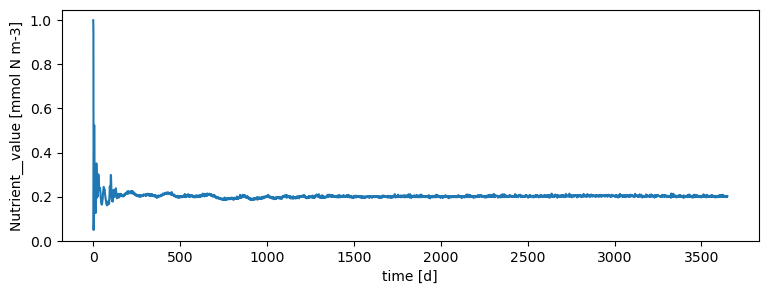

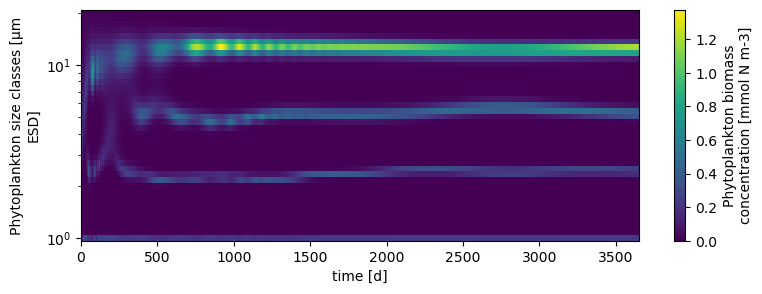

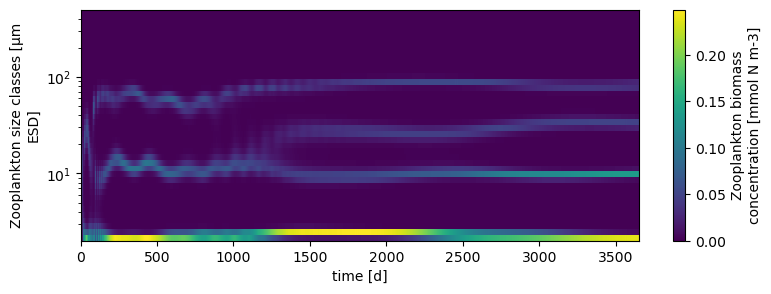

In [14]:
# let's get a quick overivew:

# plot nutrient:
model_out.Nutrient__value.plot(aspect=3, size=3, ylim=0)
# phytoplankton:
model_out.Phytoplankton__biomass.plot(yscale='log', aspect=3, size=3)
# zooplankton
model_out.Zooplankton__biomass.plot(yscale='log', aspect=3, size=3)

# Comparative model runs

Neil Banas presented a detailed analysis of model output for variable metrics of ecosystem complexity. We recreated only one part of the original analyses, with a simple comparison of model dynamics for a variable number of phytoplankton and zooplankton size classes. The number of state variables can be varied at model setup by supplying a list of initial values with the desired dimensions. We ran the model for the range of 2 to 50 size classes for our analysis presented in the publication presenting XSO and Phydra.

For the current notebook we will limit to showing 5 comparative runs, but leave you the option to modify a few lines to get the full analysis (which takes roughly 5 mins on a modern laptop).

In [15]:
# first we create a simple function wrapping our code from above to create multiple model setups:

def create_model_setup(numberoftypes):

    # number size classes of phytoplankton and zooplankotn
    PZ_num = numberoftypes
    
    # create initial biomass
    phyto_init = np.tile(.5/PZ_num, (PZ_num))
    zoo_init = np.tile(.1/PZ_num, (PZ_num))
    
    # calculate log-spaced size classes from ranges and total number
    phyto_sizes = calculate_sizes(1.,20.,PZ_num)
    zoo_sizes = 2.16 * phyto_sizes **1.79 
    
    # ingestion
    zoo_I0 = calculate_zoo_I0(zoo_sizes)
    
    # growth
    phyto_mu0 = calculate_phyto_mu0(phyto_sizes)
    phyto_ks = calculate_phyto_ks(phyto_sizes)
    
    # grazing
    preyoptsize = calculate_opt_size(zoo_sizes)
    phiP = init_phiP(phyto_sizes, preyoptsize)

    model_setup = xso.setup(solver='solve_ivp', model=NPxZxSizeBased,
                time=np.arange(0,365*10),
                input_vars={
                        # State variables
                        'Nutrient':{'value_label':'N','value_init':1.},
                        'Phytoplankton':{'biomass_label':'P','biomass_init':phyto_init, 'phyto_index':phyto_sizes},
                        'Zooplankton':{'biomass_label':'Z','biomass_init':zoo_init, 'zoo_index': zoo_sizes},
                    
                        # Flows:
                        'Inflow':{'forcing':'N0', 'rate':1., 'var':'N'},
                    
                        # Growth
                        'Growth':{'resource':'N', 'consumer':'P', 'halfsat':phyto_ks, 'mu_max':phyto_mu0},
    
                        # Grazing
                        'Grazing':{'resource':'P', 'consumer':'Z',
                                   'Imax':zoo_I0, 'KsZ':3., 'phiP':phiP},
                        'GGE':{'grazed_resource':'P', 'assimilated_consumer':'Z', 'egested_detritus':'N', 
                               'epsilon':1./3., 'f_eg':1./3.},
                    
                        # Mortality
                        'PhytoMortality':{'var':'P', 'rate':0.1*phyto_mu0},
                        'ZooMortality':{'var':'Z', 'rate':1.},
    
                        # Forcings
                        'N0':{'forcing_label':'N0', 'value':1.},
                })

    return model_setup

### Iterate over range of phytoplankton and zooplankton

to start all 48 model runs, change the range that is assigned to the `model_range` parameter.

In [16]:
from xsimlab.monitoring import ProgressBar

model_store = []

# model_range = range(2,51)
model_range = range(2,11)  # number of P and Z in model

# start loop over number of range:
for i in model_range:
    m_setup = create_model_setup(i)

    with ProgressBar():
        with NPxZxSizeBased:
            model_out = m_setup.xsimlab.run()

    ## store model output to list:
    model_store.append(model_out)
    ## for larger model runs you should save model output to disk:
    # model_out.to_netcdf('onetofifty/ASTroCAT_'+str(i)+'.nc')

             0% | initialize 

             0% | initialize 

             0% | initialize 

             0% | initialize 

             0% | initialize 

             0% | initialize 

             0% | initialize 

             0% | initialize 

             0% | initialize 

### Now sort through model output store:

In [17]:
phyto_biomass = []
biomass_lymean_phyto = []
biomass_lysd_phyto = []

# extract data to plot from model outputs
for dat in model_store:
    phyto_biomass.append(np.sum(dat.Phytoplankton__biomass, axis=0))
    biomass_lymean_phyto.append(np.mean(np.sum(dat.Phytoplankton__biomass[...,-365:], axis=0)))
    biomass_lysd_phyto.append(np.std(np.sum(dat.Phytoplankton__biomass[...,-365:], axis=0)))

full_pbm = phyto_biomass.copy()
full_blymean = biomass_lymean_phyto.copy()
full_blysd = biomass_lysd_phyto.copy()

# pick specific model runs to plot time-series for
phytolist = [x for x in [0,3,5,8,23,48] if x <= np.max(model_range) - 1]

x = list(model_range)
x_sel = []
blp_sel = []
blp_sd_sel = [] 

for val in sorted(phytolist, reverse=True):
    x_sel.append(x.pop(val)) 
    blp_sel.append(biomass_lymean_phyto.pop(val)) 
    blp_sd_sel.append(biomass_lysd_phyto.pop(val))

### Create comparitive plot

Text(0.1, 1.43, '(b)')

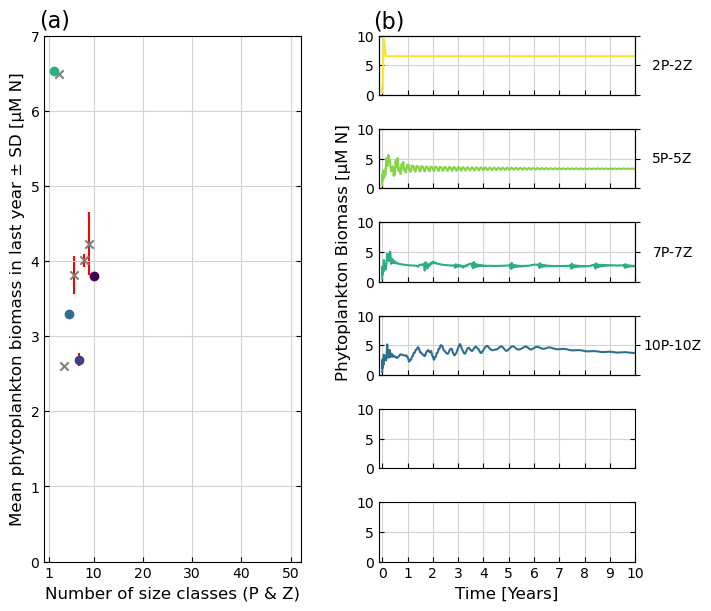

In [18]:
plt.rcParams['figure.figsize'] = [7, 6]

# get colors:
viridis = plt.get_cmap('viridis', 12)
col_list = viridis(np.linspace(0, 1, 6))

fig = plt.figure(constrained_layout=True)

gs = fig.add_gridspec(nrows=6, ncols=2,
                        hspace=0.1, wspace=0.1)

left = fig.add_subplot(gs[:6, 0])
r1 = fig.add_subplot(gs[0, 1])
r2 = fig.add_subplot(gs[1, 1])
r3 = fig.add_subplot(gs[2, 1])
r4 = fig.add_subplot(gs[3, 1])
r5 = fig.add_subplot(gs[4, 1])
r6 = fig.add_subplot(gs[5, 1])

axes = (r1, r2, r3, r4, r5, r6)

for ax in (left,)+axes:
    ax.tick_params(top=False, right=True, direction="in")
    ax.grid(True, color='lightgrey')
    
# Clones vs Biomass last year plot
left.scatter(x, biomass_lymean_phyto, color='grey', marker='x')
left.errorbar(model_range, full_blymean, full_blysd, zorder=0,
              linestyle='None', marker='', ecolor='red')

for x_, blp_, _col in zip(x_sel, blp_sel, col_list):
    left.scatter(x_, blp_, color=_col, marker='o')

left.set_xlabel("Number of size classes (P & Z)", size="large")
left.set_ylabel("Mean phytoplankton biomass in last year ± SD [µM N]", size="large")
left.set_ylim(0,7)
left.set_xlim(0,52)

plt.setp((left), xticks=[1,10,20,30,40,50])

labels = ["2P-2Z","5P-5Z","7P-7Z","10P-10Z","25P-25Z","50P-50Z"]

for _ax, _index, _col, _label in zip(axes, phytolist, col_list[::-1], labels):
    # Plots of total biomass over time for 5 example clone sizes
    _ax.plot(phyto_biomass[_index], color=_col)
    _tx = _ax.twinx()
    _tx.set_ylabel(_label, rotation=0, labelpad=20, va="center")
    _tx.set_yticklabels([])

r3.set_ylabel("Phytoplankton Biomass [µM N]", size="large")

r6.set_xlabel("Time [Years]", size="large")

left.set_axisbelow(True)

for ax in (r1, r2, r3, r4, r5, r6):
    ax.set_ylim(0,10)
    ax.set_axisbelow(True)
    
for ax in (r1, r2, r3, r4, r5):
    ax.set_xticklabels([])


xlim = (-50, 365*9+365)

plt.setp(axes, xticks=[1,365,2*365,3*365,4*365,5*365,6*365,7*365,8*365,9*365,10*365])

plt.setp(axes, xlim=xlim)

r6.set_xticklabels(labels=[i for i in range(0,11)])

# add subplot labels
left.text(0.1, 1.05, "(a)", transform=left.transAxes,
      fontsize=16, fontweight='normal', va='top', ha='right')
r1.text(0.1, 1.43, "(b)", transform=r1.transAxes,
      fontsize=16, fontweight='normal', va='top', ha='right')